# Munging the LANL netflow set in PySpark

Some remarks on the system configuration and set-up for the use of PySpark below...

The PySpark kernel can be found at <tt>~/.ipython/kernels/pyspark/kernel.json</tt>

This file contains, in field `'env'`, a subfield
<code>
  "PYSPARK_SUBMIT_ARGS": "--master local[4] pyspark-shell"
</code>

So the PySpark session should run locally and (I assumed) look in the local file system for data.

Including a valid environment variable HADOOP_HOME broke this behaviour, with the session now querying `localhost:9000` for HDFS services. 

As a fix, I now do the following before opening Jupyter notebook:
<code>
$HADOOP_HOME/sbin/start-all.sh
</code>

To check that the relevant HDSF services are up, `jps` should result in something like:
<code>
2465 Jps
1603 NameNode
1316 ResourceManager
841 DataNode
941 SecondaryNameNode
1406 NodeManager
</code>

With relevant data copied into HDFS using `hadoop fs -put`, we're good to open Jupyter...

In [1]:
# the full netflow set:

# HADOOP_HOME environment variable must be commented out (see remarks above):

path = "~/data/LANL/"
flowfile = path + "flows.txt"
flows = sc.textFile(flowfile)\
    .map(lambda line: [str(x) for x in line.split(',')])
flows.take(10)

[['1', '0', 'C1065', '389', 'C3799', 'N10451', '6', '10', '5323'],
 ['1', '0', 'C1423', 'N1136', 'C1707', 'N1', '6', '5', '847'],
 ['1', '0', 'C1423', 'N1142', 'C1707', 'N1', '6', '5', '847'],
 ['1', '0', 'C14909', 'N8191', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C14909', 'N8192', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C14909', 'N8193', 'C5720', '2049', '6', '1', '52'],
 ['1', '0', 'C1707', 'N1', 'C1423', 'N1136', '6', '4', '414'],
 ['1', '0', 'C1707', 'N1', 'C1423', 'N1142', '6', '4', '413'],
 ['1', '0', 'C1707', 'N1', 'C925', 'N10487', '6', '4', '414'],
 ['1', '0', 'C1707', 'N1', 'C925', 'N10491', '6', '4', '413']]

In [3]:
# how many flows?

flows.count()

# 129,977,412

129977412

In [25]:
# restrict to the busiest boxes (listed on file):

import re

bfile = open(path + "bbox.txt")
bbox = set([re.sub('[\"\n]+', "", s) for s in bfile.readlines()])

# index for later use:
box_indices = dict((c, i) for i, c in enumerate(bbox))
indices_box = dict((i, c) for i, c in enumerate(bbox))

# how many distinct?
len(bbox)

10109

In [26]:
# define the flow set we're interested in:

def f(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

subflows = flows.filter(lambda f: f[2] in bbox and f[4] in bbox).map(f)

In [76]:
# how many flows in the subset?

subflows.count()

# should be 129,925,366

129925366

In [32]:
# the integer features for suitable binning:

duration = subflows.map(lambda x: x[1])
packets = subflows.map(lambda x: x[7])
bytes = subflows.map(lambda x: x[8])

duration.cache()
packets.cache()
bytes.cache()

PythonRDD[52] at RDD at PythonRDD.scala:43

# Duration

In [5]:
from __future__ import print_function

duration_min = duration.min()
duration_max = duration.max()

print("Duration range:", duration_min, ",", duration_max)

Duration range: 0 , 76


Define two 'scale-free' binning functions for use below:

In [18]:
from math import floor, ceil, pow
from numpy import abs

def bin_fn(x, mn, mx, alpha, nbins):
    y_mx = pow(mx+1, -alpha)
    y_mn = pow(mn, -alpha)
    blen = abs(y_mx - y_mn)/float(nbins)
    y = pow(x, -alpha)
    return int(floor(abs(y - y_mn)/blen))

def bin_breaks(mn, mx, alpha, nbins):
    y_mx = pow(mx+1, -alpha)
    y_mn = pow(mn, -alpha)
    blen = (y_mx - y_mn)/float(nbins)
    return [round(pow(y_mn + k*blen, -1/alpha), 2) for k in range(nbins+1)]

In [274]:
duration_coef = 0.5
duration_nbins = 24

def f(x): 
    return (bin_fn(x+1, duration_min+1, duration_max+1, duration_coef, duration_nbins))
duration_lbin = duration.map(f)
duration_hist = duration_lbin.countByValue()

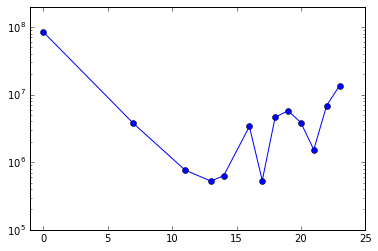

In [275]:
%matplotlib inline
import matplotlib.pyplot as plt

k = sorted(duration_hist)
v = [duration_hist[x] for x in k]
plt.semilogy(k,v)
plt.stem(k,v)

plt.axis([-1, duration_nbins+1, 1e05, 2e08])
plt.show()

In [276]:
# interpet what these values mean as packet ranges:

breaks = [round(b-1,2) for b in bin_breaks(duration_min+1, duration_max+1, duration_coef, duration_nbins)]
keys = [int(k) for k in duration_hist.keys()]
lower = [int(ceil(breaks[i])) for i in keys]
upper = [int(floor(breaks[i+1])) for i in keys]
for z in zip(keys, lower, upper): 
    print(z[0],':\t[', z[1], ',', z[2],']')

0 :	[ 0 , 0 ]
7 :	[ 1 , 1 ]
11 :	[ 2 , 2 ]
13 :	[ 3 , 3 ]
14 :	[ 4 , 4 ]
16 :	[ 5 , 6 ]
17 :	[ 7 , 7 ]
18 :	[ 8 , 10 ]
19 :	[ 11 , 13 ]
20 :	[ 14 , 18 ]
21 :	[ 19 , 27 ]
22 :	[ 28 , 43 ]
23 :	[ 44 , 77 ]


In [277]:
# free up cached memory:

duration.unpersist()

PythonRDD[50] at RDD at PythonRDD.scala:43

# Packets

In [116]:
from __future__ import print_function

packets_min = packets.min()
packets_max = packets.max()

print("Packets range:", packets_min, ",", packets_max)

Packets range: 1 , 2471188


Fit the power law distribution:

In [117]:
from math import floor, log

packets_freq = packets.map(lambda x: floor(log(x, 2))).countByValue()

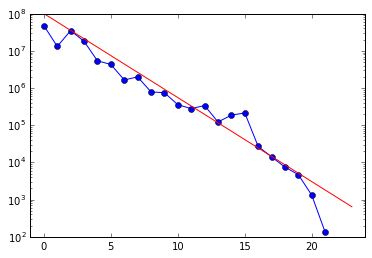

In [212]:
from math import pow

plt.semilogy(packets_freq.keys(), packets_freq.values())
plt.stem(packets_freq.keys(), packets_freq.values())

packets_coef = 0.75
x = range(24)
y = [1e08 * pow(2, -t*packets_coef) for t in x]
plt.plot(x,y, c='r')

plt.axis([-1,24,1e02,1e08])
plt.show()

Now apply this coefficient to the binning procedure:

In [213]:
packets_nbins = 32

packets_lbin = packets.map(lambda x: bin_fn(x, packets_min, packets_max, packets_coef, packets_nbins))
packets_hist = packets_lbin.countByValue()

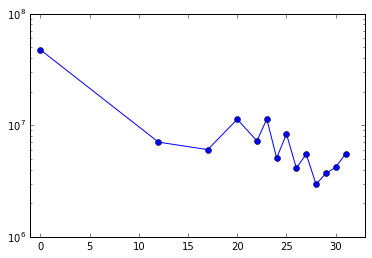

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt

k = sorted(packets_hist)
v = [packets_hist[x] for x in k]
plt.semilogy(k,v)
plt.stem(k,v)

plt.axis([-1,33,1e06,1e08])
plt.show()

In [239]:
# interpet what these values mean as packet ranges:

breaks = [round(b,2) for b in bin_breaks(packets_min, packets_max, packets_coef, packets_nbins)]
keys = [int(k) for k in packets_hist.keys()]
lower = [int(ceil(breaks[i])) for i in keys]
upper = [int(floor(breaks[i+1])) for i in keys]
for z in zip(keys, lower, upper): 
    print(z[0],':\t[', z[1], ',', z[2],']')

0 :	[ 1 , 1 ]
12 :	[ 2 , 2 ]
17 :	[ 3 , 3 ]
20 :	[ 4 , 4 ]
22 :	[ 5 , 5 ]
23 :	[ 6 , 6 ]
24 :	[ 7 , 7 ]
25 :	[ 8 , 9 ]
26 :	[ 10 , 11 ]
27 :	[ 12 , 16 ]
28 :	[ 16 , 23 ]
29 :	[ 24 , 40 ]
30 :	[ 41 , 101 ]
31 :	[ 102 , 2471189 ]


In [236]:
# free up cached memory:

packets.unpersist()

PythonRDD[4] at RDD at PythonRDD.scala:43

# Bytes

In [33]:
from __future__ import print_function

bytes_min = bytes.min()
bytes_max = bytes.max()

print("Bytes range:", bytes_min, ",", bytes_max)

ValueError: Can not reduce() empty RDD

Let's take a look at the power law distribution:

In [14]:
from math import floor, log

bytes_freq = bytes.map(lambda x: floor(log(x, 2))).countByValue()

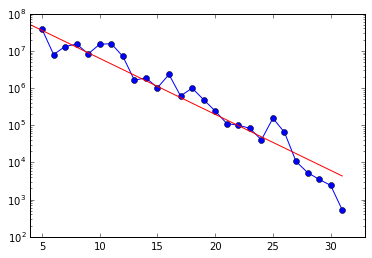

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.semilogy(bytes_freq.keys(), bytes_freq.values())
plt.stem(bytes_freq.keys(), bytes_freq.values())

bytes_coef = 0.5
x = range(4,32)
y = [2e08 * pow(2, -t*bytes_coef) for t in x]

plt.plot(x,y, c='r')

plt.axis([4,33,1e02,1e08])
plt.show()

Now apply this coefficient to the binning procedure:

In [19]:
bytes_nbins = 32

# function bin_fn() defined earlier

bytes_lbin = bytes.map(lambda x: bin_fn(x, bytes_min, bytes_max, bytes_coef, bytes_nbins))
bytes_hist = bytes_lbin.countByValue()

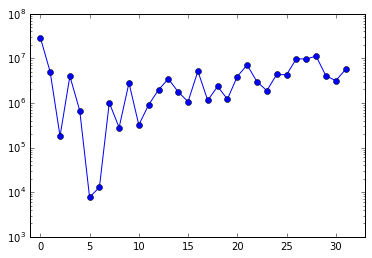

In [20]:
plt.semilogy(bytes_hist.keys(), bytes_hist.values())
plt.stem(bytes_hist.keys(), bytes_hist.values())
plt.axis([-1,33,1e03,1e08])
plt.show()

In [256]:
# interpet what these values mean as packet ranges:

# function bin_breaks() defined earlier

breaks = [round(b,2) for b in bin_breaks(bytes_min, bytes_max, bytes_coef, bytes_nbins)]
keys = [int(k) for k in bytes_hist.keys()]
lower = [int(ceil(breaks[i])) for i in keys]
upper = [int(floor(breaks[i+1])) for i in keys]
for z in zip(keys, lower, upper): 
    print(z[0],':\t[', z[1], ',', z[2],']')

0 :	[ 46 , 49 ]
1 :	[ 50 , 52 ]
2 :	[ 53 , 56 ]
3 :	[ 57 , 60 ]
4 :	[ 61 , 64 ]
5 :	[ 65 , 69 ]
6 :	[ 70 , 75 ]
7 :	[ 76 , 81 ]
8 :	[ 82 , 89 ]
9 :	[ 90 , 97 ]
10 :	[ 98 , 106 ]
11 :	[ 107 , 117 ]
12 :	[ 118 , 130 ]
13 :	[ 131 , 145 ]
14 :	[ 146 , 162 ]
15 :	[ 163 , 183 ]
16 :	[ 184 , 209 ]
17 :	[ 210 , 240 ]
18 :	[ 241 , 278 ]
19 :	[ 279 , 326 ]
20 :	[ 327 , 389 ]
21 :	[ 390 , 470 ]
22 :	[ 471 , 581 ]
23 :	[ 582 , 735 ]
24 :	[ 736 , 960 ]
25 :	[ 961 , 1306 ]
26 :	[ 1307 , 1881 ]
27 :	[ 1882 , 2938 ]
28 :	[ 2939 , 5220 ]
29 :	[ 5221 , 11729 ]
30 :	[ 11730 , 46723 ]
31 :	[ 46724 , 2681847377 ]


In [28]:
# free up cached memory:
bytes.unpersist()

PythonRDD[40] at RDD at PythonRDD.scala:43

# Protocol and ports

In [278]:
protocol = subflows.map(lambda x: x[6])
protocol.countByValue()

defaultdict(int, {1: 3316583, 6: 116505060, 17: 10103232, 41: 491})

In [12]:
def normal_port(x, i):
    if re.match('^N', x[i])!=None: 
        return 'N' 
    else: 
        return int(x[i])

src_port = subflows.map(lambda x: normal_port(x,3))
src_port_set = src_port.countByValue()
src_port_set

defaultdict(int,
            {1: 2378,
             7: 872,
             9: 841,
             11: 408,
             13: 870,
             15: 390,
             17: 876,
             18: 384,
             19: 876,
             20: 1424,
             21: 1022,
             22: 262264,
             23: 1005,
             25: 1281,
             37: 868,
             42: 871,
             43: 872,
             49: 874,
             50: 396,
             53: 6406,
             57: 407,
             65: 405,
             67: 398,
             68: 811,
             69: 4,
             70: 856,
             77: 417,
             79: 912,
             80: 3957306,
             87: 391,
             88: 2989193,
             95: 403,
             98: 386,
             101: 374,
             102: 398,
             104: 402,
             105: 399,
             106: 867,
             107: 389,
             109: 872,
             110: 1051,
             111: 233278,
             113: 993,
           

In [13]:
dst_port = subflows.map(lambda x: f(x,5))
dst_port_set = dst_port.countByValue()
dst_port_set

defaultdict(int,
            {1: 2794,
             7: 1631,
             9: 1323,
             11: 666,
             13: 1690,
             15: 653,
             17: 1207,
             18: 661,
             19: 1636,
             20: 1582,
             21: 1488,
             22: 651987,
             23: 1292,
             25: 1746,
             37: 1124,
             42: 1267,
             43: 1280,
             49: 1288,
             50: 640,
             53: 13260,
             57: 639,
             65: 699,
             67: 1110,
             68: 658,
             69: 4395,
             70: 1184,
             77: 553,
             79: 1239,
             80: 4810348,
             87: 635,
             88: 2019214,
             95: 677,
             98: 705,
             101: 715,
             102: 666,
             104: 675,
             105: 738,
             106: 1113,
             107: 690,
             109: 1219,
             110: 1297,
             111: 237166,
             113

In [74]:
# index union of src/dst ports:

portset = set(src_port_set.keys()).union(set(dst_port_set.keys()))
port_indices = dict((c, i) for i, c in enumerate(portset))
indices_port = dict((i, c) for i, c in enumerate(portset))

indices_port

{0: 2049,
 1: 2053,
 2: 1,
 3: 9,
 4: 11,
 5: 13,
 6: 15,
 7: 17,
 8: 18,
 9: 19,
 10: 20,
 11: 21,
 12: 22,
 13: 23,
 14: 25,
 15: 5151,
 16: 37,
 17: 2086,
 18: 42,
 19: 7,
 20: 49,
 21: 50,
 22: 2101,
 23: 2102,
 24: 2103,
 25: 1080,
 26: 2105,
 27: 3130,
 28: 2111,
 29: 65,
 30: 67,
 31: 68,
 32: 1093,
 33: 70,
 34: 2119,
 35: 2121,
 36: 1099,
 37: 77,
 38: 79,
 39: 80,
 40: 5190,
 41: 1109,
 42: 2135,
 43: 88,
 44: 4190,
 45: 95,
 46: 98,
 47: 101,
 48: 5222,
 49: 1127,
 50: 104,
 51: 105,
 52: 106,
 53: 11371,
 54: 109,
 55: 110,
 56: 111,
 57: 113,
 58: 115,
 59: 117,
 60: 119,
 61: 123,
 62: 4224,
 63: 129,
 64: 135,
 65: 137,
 66: 138,
 67: 139,
 68: 143,
 69: 30865,
 70: 5269,
 71: 1178,
 72: 7100,
 73: 161,
 74: 162,
 75: 163,
 76: 164,
 77: 1194,
 78: 174,
 79: 177,
 80: 178,
 81: 179,
 82: 1210,
 83: 5308,
 84: 9418,
 85: 1214,
 86: 191,
 87: 194,
 88: 199,
 89: 201,
 90: 6346,
 91: 6347,
 92: 204,
 93: 546,
 94: 206,
 95: 209,
 96: 210,
 97: 5667,
 98: 1236,
 99: 213,
 10

In [77]:
import json

json.dump(
    {
    'box_indices': box_indices,
    'indices_box': indices_box,
    'port_indices': port_indices,
    'indices_port': indices_port
    },
    open("boxport_data.json", 'w')
)

# Experimenting with a smaller RDD (skip)

Let's write to disk, then read in to the session, the small set of protocol 41 flows:

In [126]:
# pull out subset and write to disk:

def toCSVline(data):
  return ','.join(str(d) for d in data)

subflows.filter(lambda x: x[6]==41).map(toCSVline).saveAsTextFile("tmp")

In [5]:
# read from disk to new RDD:

def f(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

tmp_rdd = sc.textFile("tmp").map(lambda line: [str(x) for x in line.split(',')]).map(f)
tmp_rdd.take(5)

[[132720, 13, 'C12651', 'N41444', 'C528', 'N41444', 41, 2, 184],
 [134106, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [134465, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [134826, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92],
 [135185, 0, 'C12651', 'N16749', 'C528', 'N16749', 41, 1, 92]]

In [6]:
# how many lines?

tmp_rdd.count()

491

# Generate definitive data set for RNN model

In [279]:
# load box/port info from json:

import json
import re

data = json.load(open("data/boxport_data.json", 'r'))

def jsonIntKeys(x):
    if isinstance(x, dict):
            return {int(k):str(v) for k,v in x.items()}
    return x

def jsonIntVals(x):
    if isinstance(x, dict):
            return {str(k):int(v) for k,v in x.items()}
    return x

box_index = jsonIntVals( data['box_indices'] )
index_box = jsonIntKeys( data['indices_box'] )
port_index = jsonIntVals( data['port_indices'] )
index_port = jsonIntKeys( data['indices_port'] )

bbox = set([re.sub('[\"\n]+', "", s) for s in box_index.keys()])

In [280]:
# define netflow RDD - filter to boxes in 'bbox' (busy computers):

flowfile = path + "flows.csv"
flows = sc.textFile(flowfile).map(lambda line: [str(x) for x in line.split(',')])

def filt(x):
    return [int(x[0]), int(x[1]), x[2], x[3], x[4], x[5], int(x[6]), int(x[7]), int(x[8])]

subflows = flows.filter(lambda f: f[2] in bbox and f[4] in bbox).map(filt)

In [281]:
duration_nbins = 24
packets_nbins = 32
bytes_nbins = 32

In [287]:
# define normalisation mapping to be readable in Keras:

from math import log, floor

protocols = [1,6,17,41]
proto_index = dict((c, i) for i, c in enumerate(protocols))
index_proto = dict((i, c) for i, c in enumerate(protocols))

def duration_bin(x):
    return bin_fn(x+1, duration_min+1, duration_max+1, duration_coef, duration_nbins)
def packets_bin(x):
    return bin_fn(x, packets_min, packets_max, packets_coef, packets_nbins)
def bytes_bin(x):
    return bin_fn(x, bytes_min, bytes_max, bytes_coef, bytes_nbins)

def normal_port(x):
    if re.match('^N', x)!=None: 
        return 'N' 
    else: 
        return x

def normalise(x):
    return [x[0], 
            duration_bin(x[1]),
            box_index[x[2]],
            port_index[normal_port(x[3])],
            box_index[x[4]],
            port_index[normal_port(x[5])],
            proto_index[x[6]], 
            packets_bin(x[7]), 
            bytes_bin(x[8])]

# check:
subflows.map(normalise).take(10)

[[1, 0, 9501, 138, 2205, 122, 1, 26, 29],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 2244, 122, 8986, 122, 1, 22, 24],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 5354, 122, 9484, 0, 1, 0, 1],
 [1, 0, 8986, 122, 2244, 122, 1, 20, 21],
 [1, 0, 8986, 122, 2244, 122, 1, 20, 21],
 [1, 0, 8986, 122, 2408, 122, 1, 20, 21],
 [1, 0, 8986, 122, 2408, 122, 1, 20, 21]]

In [288]:
# write to disk:

def toCSVline(data):
  return ','.join(str(d) for d in data)

subflows.map(normalise).map(toCSVline).saveAsTextFile(path + "flows_for_rnn_model")

#outfile = open(path + "flows_for_rnn_model_100000.csv", 'w')
#output = subflows.map(normalise).map(toCSVline).take(100000)
#for line in output: outfile.write(line + '\n')
#outfile.close()

Then run in the output directory:

cat part-* | sort -g -k1 | bzip2 -c > flows_for_rnn_model.bz2

# Further EDA

In [7]:
normflows = subflows.map(normalise)

normduration = normflows.map(lambda x: x[1])
normduration = normflows.map(lambda x: x[1])
normpackets = normflows.map(lambda x: x[7])
normbytes = normflows.map(lambda x: x[8])

In [12]:
normduration.countByValue()

# should agree with
# {0: 84193649,
#  1: 4499644,
#  2: 4529776,
#  3: 12052081,
#  4: 5755560,
#  5: 16689791,
#  6: 2204865}
# from above.

defaultdict(int,
            {0: 84193649,
             1: 4499644,
             2: 4529776,
             3: 12052081,
             4: 5755560,
             5: 16689791,
             6: 2204865})

In [12]:
# how many src computers are typically seen within 1-sec time bins?

src_process = normflows.map(lambda x: [x[0], x[2]]).groupByKey().cache()

In [ ]:
# histogram of '1-sec sharing':

def f(y):
    return float(len(set(y)))/float(len(y))

h = src_process.sortBy(lambda x: x[0]).map(lambda x : f(list(x[1]))).collect()

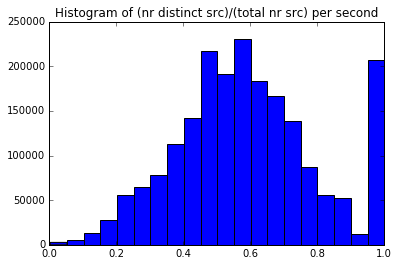

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(h, bins=20)
plt.title("Histogram of (nr distinct src)/(total nr src) per second")
plt.show()

This shows that a typical src computer will appear twice ina typical 1-second time bin. Is this uniform over time? 

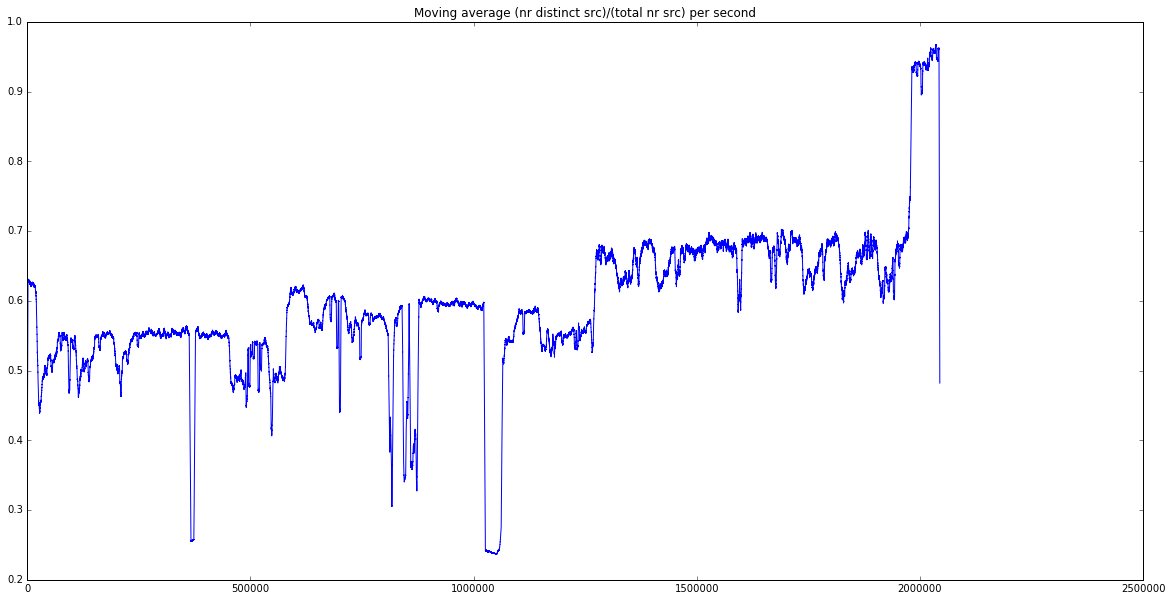

In [61]:
# how does this sharing proportion vary with time?

import numpy as np

def movingaverage(x, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(x, window, 'same')

plt.figure(figsize=(20,10))
plt.plot(movingaverage(h, 3600))
plt.title("Moving average (nr distinct src)/(total nr src) per second")
plt.show()

# Ashley's periodicity observation

There is something odd about the duration field, I have several examples of oddities. 

On port 445 (Microsoft Directory Services) there are examples of inconsistencies but I wouldn't be surprised if they did keep opening and shutting tcp connections on the same ports.

For example: on source C7513:1094 destination  C5720:445 there is a tcp session for over a week, where most of the time a new record is started every 68.3 seconds of duration 34.4 seconds.

More likely to show a problem in collection and/or anonymisation is ssh where in this example in one direction the duration 72, exceeds the time between records.

Also looks at:
<ul>
<li>
duration=72, source_computer=C15733, source_port=N1, destination_computer=C5696, destination_port=22, protocol=6 
<li>
source_computer=C5696, source_port=22, destination_computer=C15733, destination_port=N1, protocol=6
</ul>

In [13]:
# check these are all in bbox, so we can restrict to subflows:

[x in bbox for x in ['C7513','C5720','C15733','C5696']]

[True, True, True, True]

In [15]:
def outflows(comp):
    return subflows.filter(lambda x: x[2]==comp)

def inflows(comp):
    return subflows.filter(lambda x: x[4]==comp)

In [23]:
comp = 'C15733'

dat = outflows(comp)
dat.cache()
dat.count()

44722

In [69]:
# group by destination computers:

from __future__ import print_function

edges = dat.groupBy(lambda x: x[4]).map(lambda x : (x[0], list(x[1]))).collect()
for x in edges:
    print(x[0], '\t', len(x[1]))

C1685 	 11227
C1883 	 482
C26408 	 9
C604 	 1706
C1707 	 6508
C529 	 3
C3028 	 45
C5900 	 22
C5720 	 14902
C5760 	 3490
C5696 	 6295
C4592 	 33


In [70]:
# for example:

edges[2]

('C26408',
 [[563779, 1, 'C15733', 'N16432', 'C26408', '443', 6, 14, 2121],
  [563780, 1, 'C15733', 'N9583', 'C26408', '443', 6, 15, 2019],
  [563781, 0, 'C15733', 'N20453', 'C26408', '443', 6, 11, 1811],
  [563781, 0, 'C15733', 'N21346', 'C26408', '443', 6, 22, 2783],
  [563781, 0, 'C15733', 'N21505', 'C26408', '443', 6, 11, 1811],
  [563781, 0, 'C15733', 'N37865', 'C26408', '443', 6, 11, 1795],
  [563781, 0, 'C15733', 'N3926', 'C26408', '443', 6, 11, 1683],
  [563808, 1, 'C15733', 'N18740', 'C26408', '443', 6, 11, 2083],
  [563809, 0, 'C15733', 'N27357', 'C26408', '443', 6, 22, 2927]])

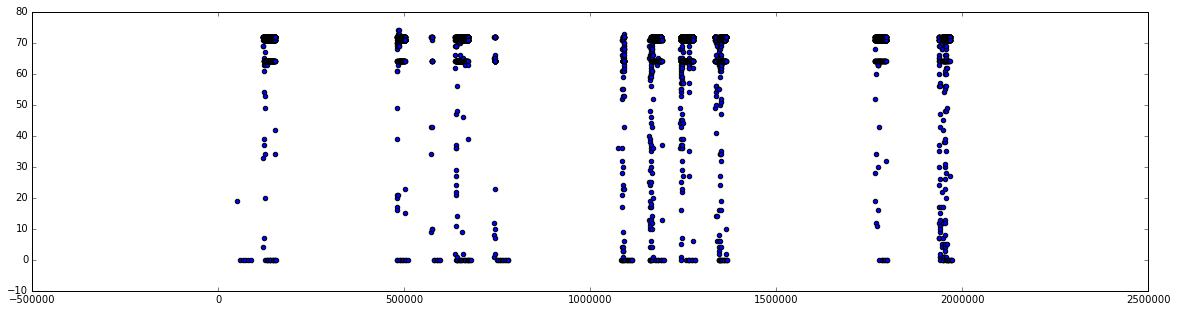

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

dst = 'C5696'

idx = [x[0] for x in edges].index(dst)
traffic = edges[idx][1]
time = [x[0] for x in traffic]
dur = [x[1] for x in traffic]

plt.figure(figsize=(20,5))
plt.scatter(time, dur)